In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit   
from scipy.interpolate import interp1d

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }
mean_cvir = {
    "SymphonyLMC": 12.2,
    "SymphonyMilkyWay": 10.8,
    "SymphonyGroup": 9.0,
    "SymphonyLCluster": 5.0,
    "SymphonyCluster": 5.6,
}
out_dir = os.path.join(base_dir, "output", "FIGURE")

In [ ]:
def quantify_correlation(base_dir, suite_names, r_target=0.01, x_var="cvir", slope_var="slope_Q_r"):
    """ 
    Quantify the correlation between PPSD slope and halo properties: concentration or accretion rate at target radius.
    """
    slope_vals, x_vals, mass_vals = [], [], []

    for suite in suite_names:
        slope_r_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        cvir_path = os.path.join(base_dir, "output", suite, "halo_concentrations.csv")
        gamma_path = os.path.join(base_dir, "output", suite, "accretion_rates.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        df_cvir = pd.read_csv(cvir_path)
        df_gamma = pd.read_csv(gamma_path)
        cvir_dict = dict(zip(df_cvir["halo_id"], df_cvir["cvir"]))
        gamma_dict = dict(zip(df_gamma["halo_index"], df_gamma["gamma"]))
        mass_dict = dict(zip(pd.read_csv(mass_path)["halo_id"], pd.read_csv(mass_path)["mvir"]))

        if x_var == "delta_c_norm":
            c_vals = df_cvir["cvir"].values
            c_med = np.nanmedian(c_vals)
            c_std = np.nanstd(c_vals)
            delta_c_dict = {row["halo_id"]: (row["cvir"] - c_med) / c_std for _, row in df_cvir.iterrows()}

        elif x_var == "delta_gamma_norm":
            valid_gamma = df_gamma["gamma"].values
            valid_mask = (valid_gamma > 0) & np.isfinite(valid_gamma)
            log_g_vals = np.log10(valid_gamma[valid_mask])

            log_g_med = np.nanmedian(log_g_vals)
            log_g_std = np.nanstd(log_g_vals)

            delta_g_dict = {
                row["halo_index"]: (np.log10(row["gamma"]) - log_g_med) / log_g_std
                for _, row in df_gamma.iterrows()
                if row["gamma"] > 0 and np.isfinite(row["gamma"])
            }

        for f in sorted([f for f in os.listdir(slope_r_dir) if f.endswith(".csv")]):
            try:
                halo_id = int(f.split("_")[1])
                df = pd.read_csv(os.path.join(slope_r_dir, f))
                r = df["r_scaled"].values
                slope = df[slope_var].values
                interp_func = interp1d(r, slope, bounds_error=False, fill_value=np.nan)
                slope_val = float(interp_func(r_target))

                if x_var == "cvir":
                    x = cvir_dict.get(halo_id)
                elif x_var == "gamma":
                    x = gamma_dict.get(halo_id)
                elif x_var == "delta_c_norm":
                    x = delta_c_dict.get(halo_id)
                elif x_var == "delta_gamma_norm":
                    x = delta_g_dict.get(halo_id)
                else:
                    raise ValueError(f"Unsupported x_var: {x_var}")

                mass = mass_dict.get(halo_id, np.nan)
                try:
                    slope_val = float(interp_func(r_target))
                    x = float(x) 
                    mass = float(mass)
                except Exception as e:
                    continue
                if np.isfinite(slope_val) and np.isfinite(x) and (x_var != "gamma" or x > 0):
                    slope_vals.append(slope_val)
                    x_vals.append(x)
                    mass_vals.append(mass)
            except Exception as e:
                print(f"[Warning] Failed to process {f} in {suite}: {e}")
                continue

    slope_vals = np.array(slope_vals)
    x_vals = np.array(x_vals)
    mass_vals = np.array(mass_vals)

    if len(slope_vals) < 2:
        print("[Warning] Not enough valid data to compute correlation.")
        return

    log_mass = np.log10(mass_vals)
    log_x = np.log10(x_vals) if x_var == "gamma" else x_vals

    spearman_r, spearman_p = spearmanr(log_x, slope_vals)

    plt.figure(figsize=(7, 6), dpi=500)
    scatter = plt.scatter(log_x, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8, edgecolors='none')
    cbar = plt.colorbar(scatter, label=r"$\log_{10}(M_{\rm vir} / M_\odot)$")

    xlabel_map = {
        "cvir": r"$c_{\rm vir}$",
        "gamma": r"$\log_{10}(\gamma)$",
        "delta_c_norm": r"$(c - \tilde{c}) / \sigma_c$",
        "delta_gamma_norm": r"$(\gamma - \tilde{\gamma}) / \sigma_\gamma$"
    }
    plt.xlabel(xlabel_map.get(x_var, x_var))
    plt.ylabel(fr"{slope_var} at $r = {r_target:.3f} R_{{\rm vir}}$")
    plt.title(f"Correlation at $r = {r_target} R_{{\\rm vir}}$")
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}",
        rf"$p$ = {spearman_p:.2e}"
    ))
    plt.text(0.97, 0.03, textstr,
             transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    plt.show()
    
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
quantify_correlation(
    base_dir, suite_names,
    r_target=1,
    x_var="delta_gamma_norm",
    slope_var="slope_Q_r"
)

quantify_correlation(
    base_dir, suite_names,
    r_target=1,
    x_var="delta_c_norm",
    slope_var="slope_Q_r"
)

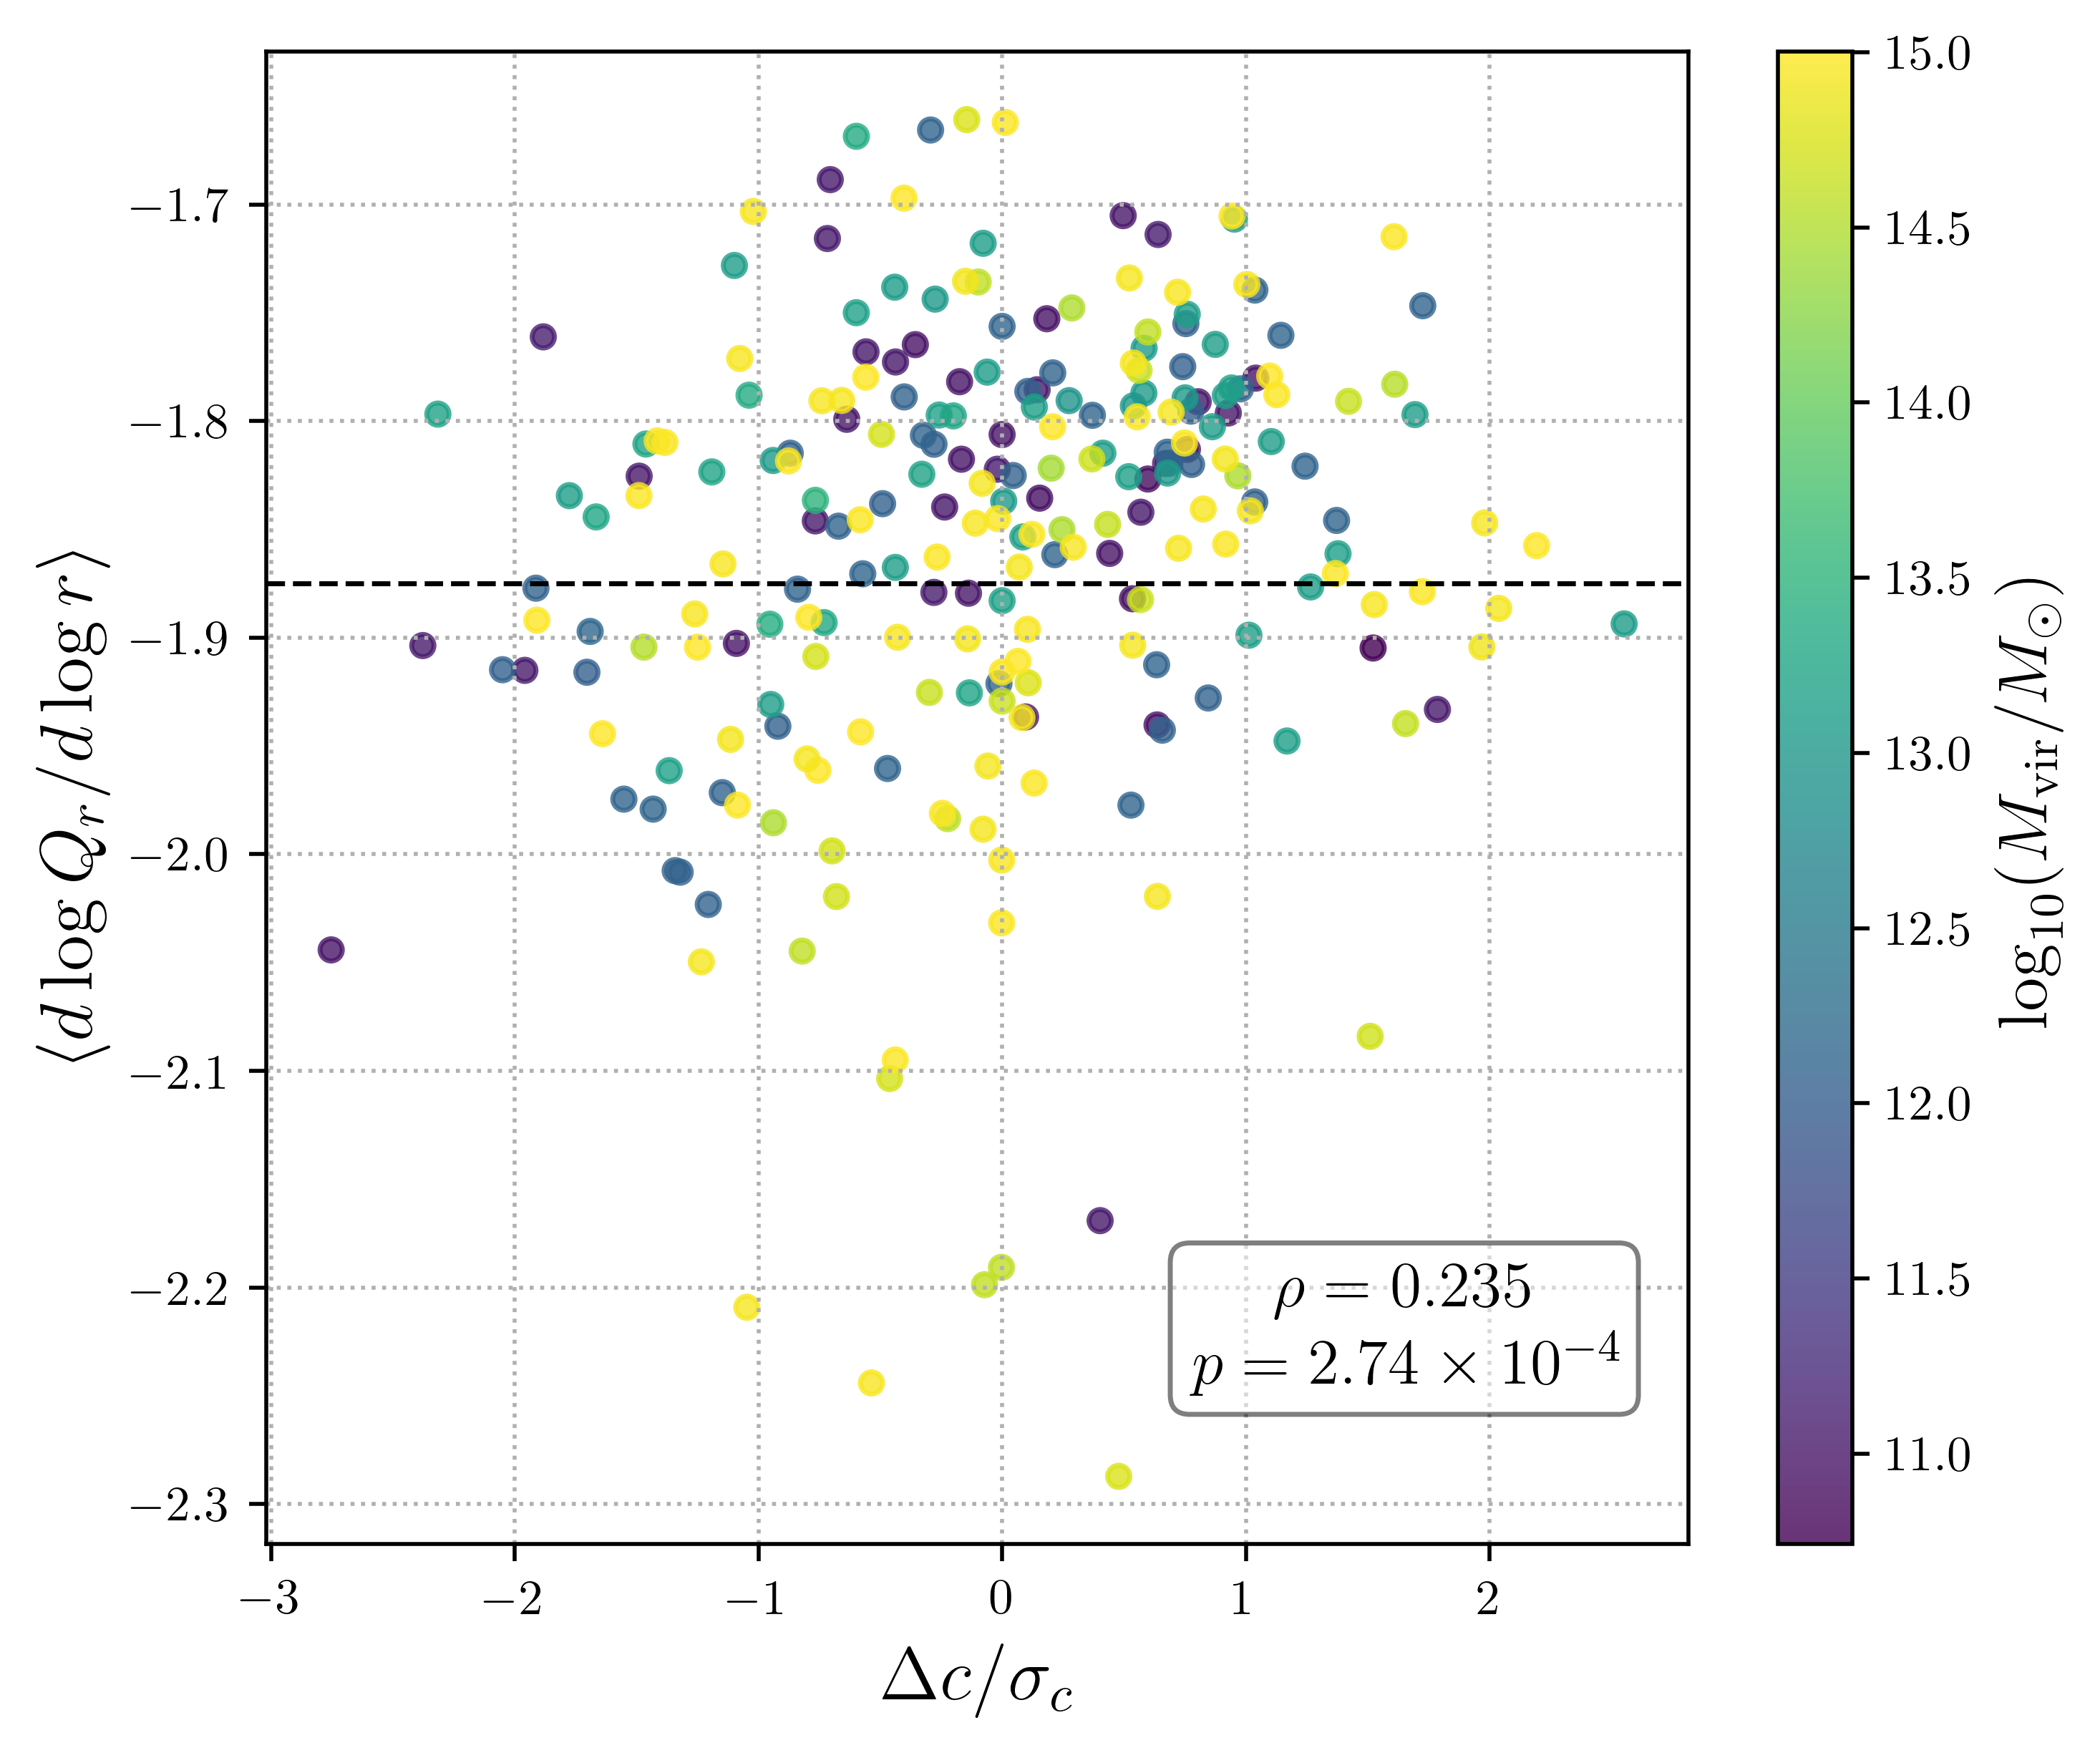

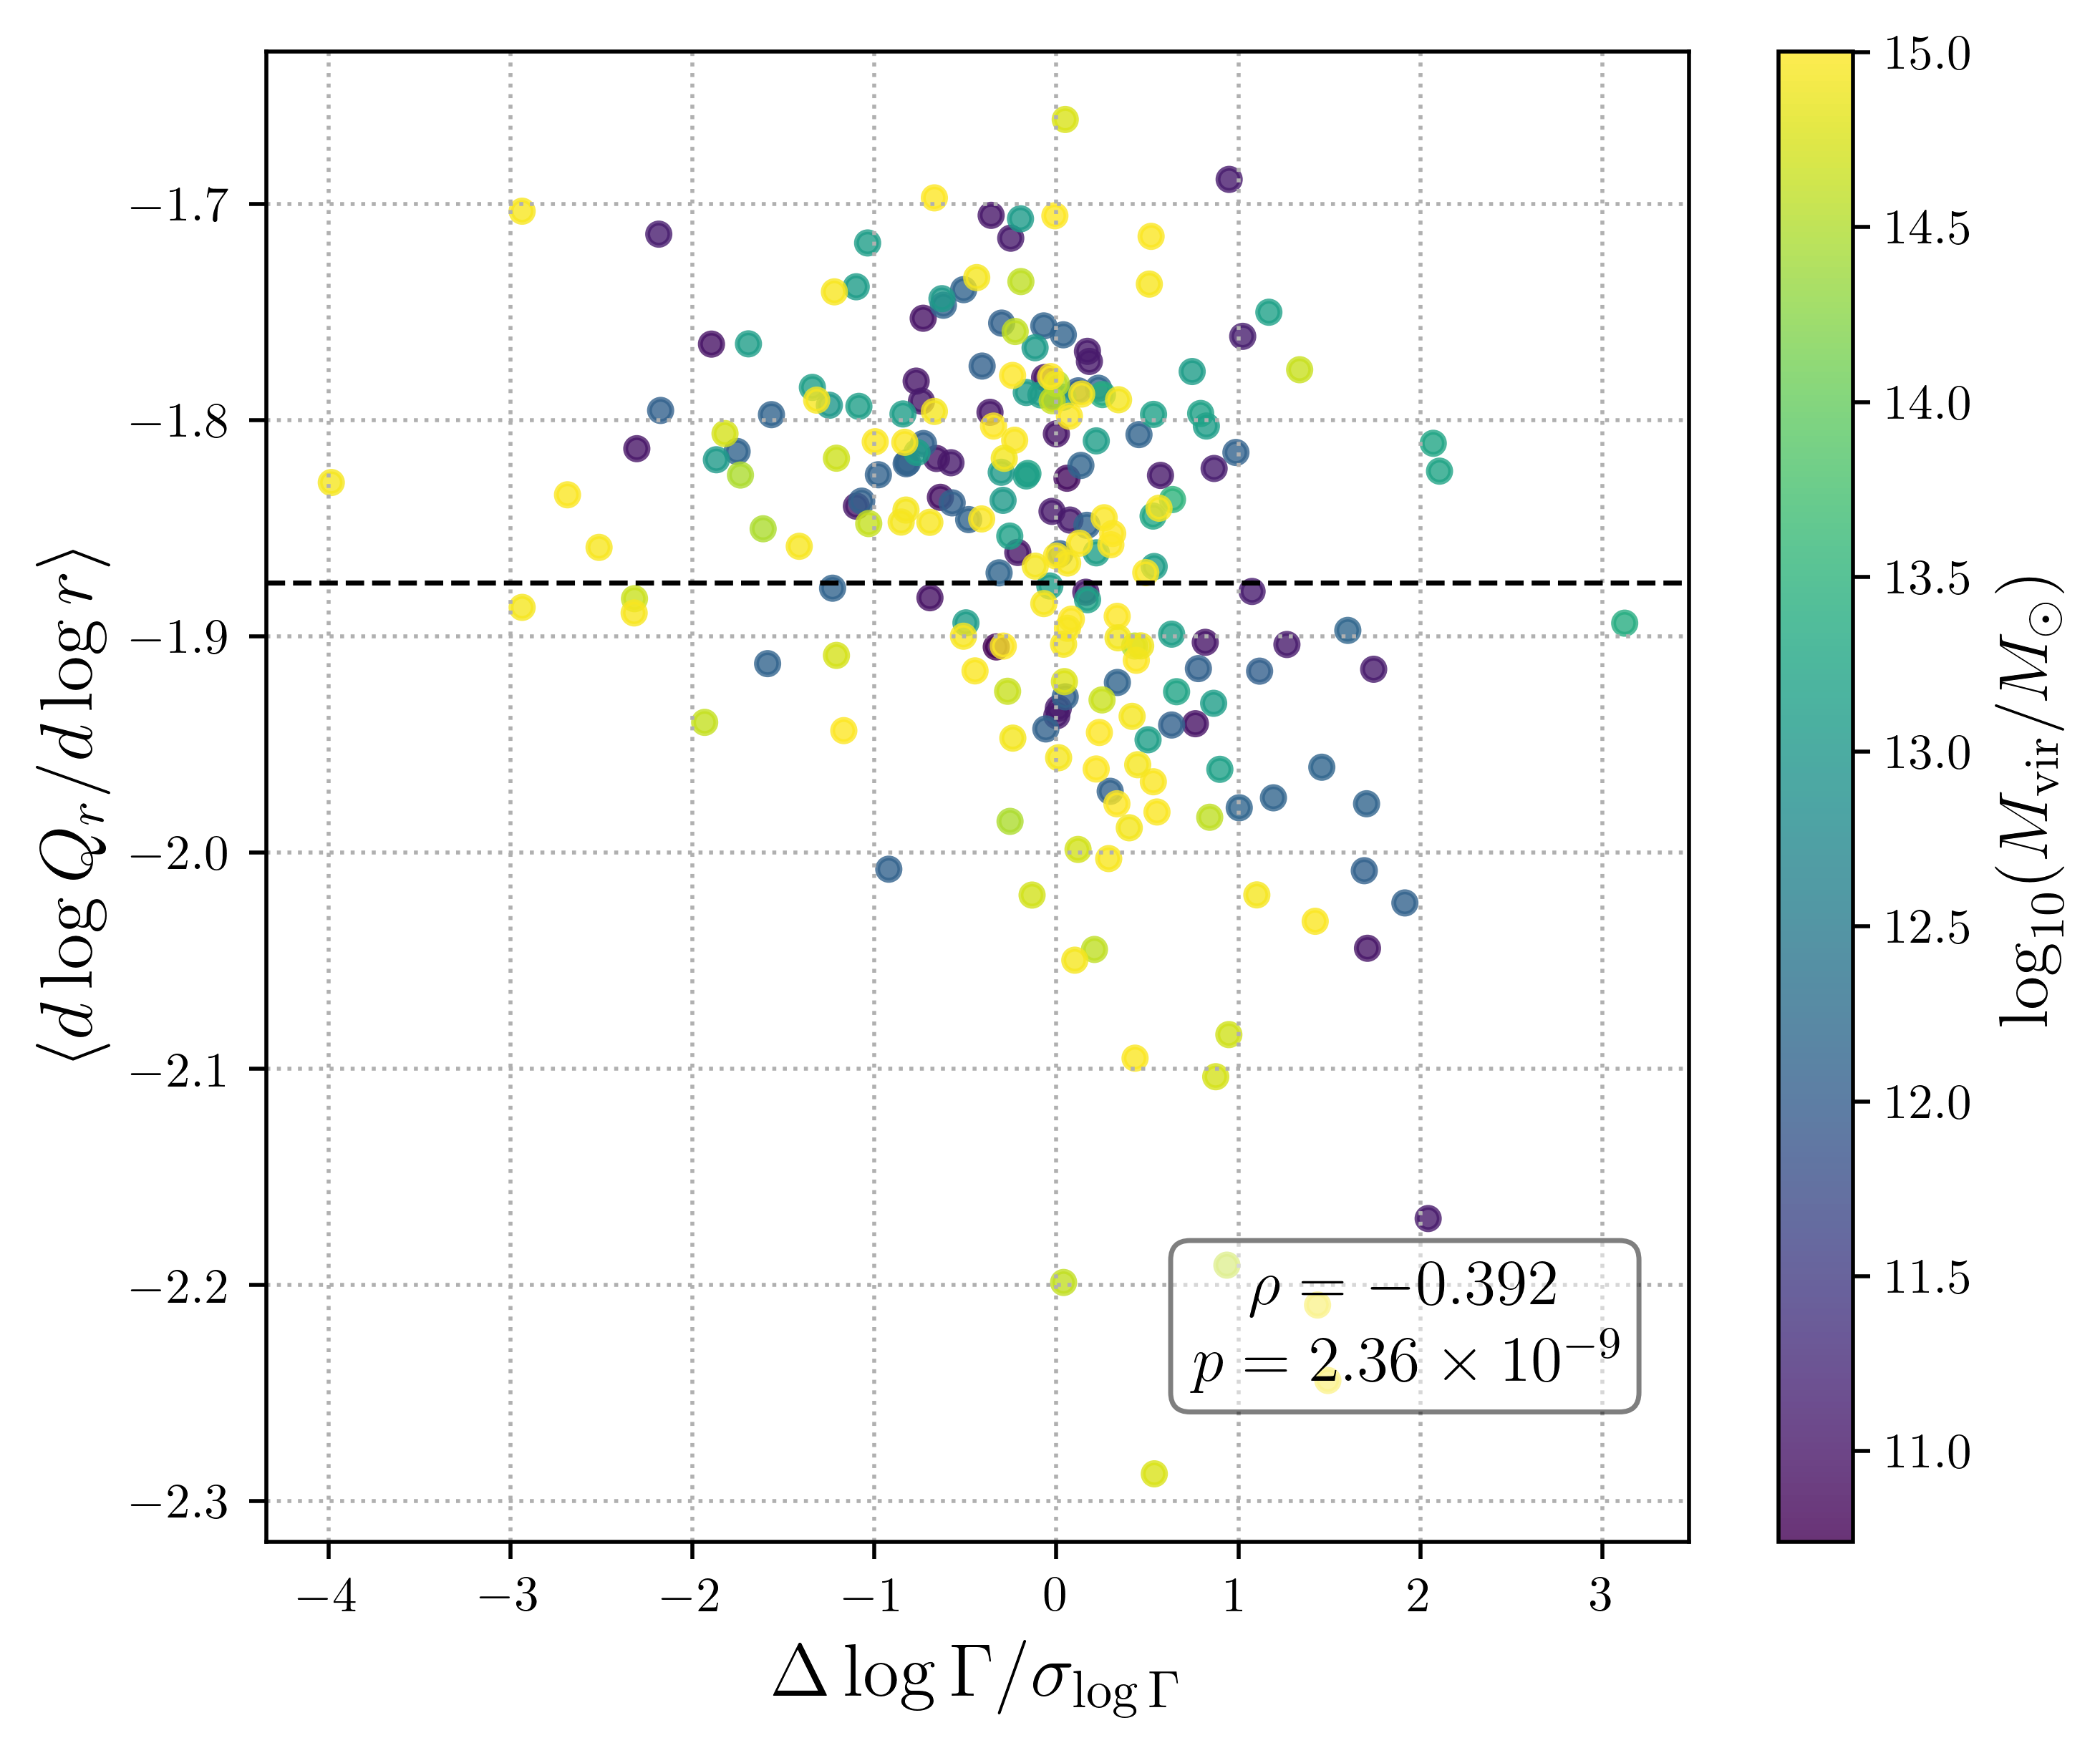

In [24]:
def const_model(r, a):
    """Constant model for curve_fit."""
    return a * np.ones_like(r)

def sci_notation_latex(x, precision=2):
    """
    Return a string like 1.23e-4 → 1.23 \\times 10^{-4}
    """
    fmt = f"{x:.{precision}e}"
    base, exponent = fmt.split("e")
    return rf"{base} \times 10^{{{int(exponent)}}}"

def best_slope_vs_cgamma(base_dir, suite_names,
                          x_var="cvir",
                          slope_column="slope_Q_r",
                          fit_range=(0.01, 1.0),
                          clip_sigma=2.5):

    slope_vals, slope_errs, x_vals, mass_vals = [], [], [], []

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")

        df_cvir  = pd.read_csv(os.path.join(base_dir, "output", suite, "halo_concentrations.csv"))
        df_gamma = pd.read_csv(os.path.join(base_dir, "output", suite, "accretion_rates.csv"))
        df_mass  = pd.read_csv(os.path.join(base_dir, "output", suite, "halo_mass.csv"))

        cvir_dict  = dict(zip(df_cvir["halo_id"], pd.to_numeric(df_cvir["cvir"], errors='coerce')))
        gamma_dict = dict(zip(df_gamma["halo_index"], pd.to_numeric(df_gamma["gamma"], errors='coerce')))
        mass_dict  = dict(zip(df_mass["halo_id"], pd.to_numeric(df_mass["mvir"], errors='coerce')))

        if x_var == "delta_c_norm":
            cm, cstd = df_cvir["cvir"].median(), df_cvir["cvir"].std()
            delta_c_dict = {hid: (c - cm) / cstd
                            for hid, c in zip(df_cvir["halo_id"], df_cvir["cvir"])}

        if x_var == "delta_gamma_norm":
            g = pd.to_numeric(df_gamma["gamma"], errors='coerce')
            mask = (g > 0) & g.notna()
            lg = np.log10(g[mask])
            gm, gstd = lg.median(), lg.std()
            delta_g_dict = {idx: (np.log10(gamma) - gm) / gstd
                            for idx, gamma in zip(df_gamma["halo_index"], g)
                            if gamma > 0 and pd.notna(gamma)}

        for fname in sorted(f for f in os.listdir(slope_dir) if f.endswith(".csv")):
            try:
                hid = int(fname.split("_")[1])
            except Exception:
                continue

            try:
                df = pd.read_csv(os.path.join(slope_dir, fname))
                r  = df["r_scaled"].to_numpy(dtype=float)
                sQ = pd.to_numeric(df[slope_column], errors='coerce').to_numpy(dtype=float)
                mask = (r >= fit_range[0]) & (r <= fit_range[1]) & np.isfinite(sQ)
                if mask.sum() < 3:
                    continue

                popt, pcov = curve_fit(const_model, r[mask], sQ[mask],
                                       p0=np.mean(sQ[mask]),
                                       maxfev=10000)
                slope_fit = popt[0]
                slope_err = np.sqrt(np.diag(pcov))[0] if pcov.size else np.nan

                if   x_var == "cvir":             x = cvir_dict.get(hid,  np.nan)
                elif x_var == "gamma":            x = gamma_dict.get(hid, np.nan)
                elif x_var == "delta_c_norm":     x = delta_c_dict.get(hid, np.nan)
                elif x_var == "delta_gamma_norm": x = delta_g_dict.get(hid, np.nan)
                else:
                    raise ValueError(f"Unsupported x_var: {x_var}")

                mass = mass_dict.get(hid, np.nan)

                if np.isfinite(slope_fit) and np.isfinite(x):
                    slope_vals.append(slope_fit)
                    slope_errs.append(slope_err)
                    x_vals.append(x)
                    mass_vals.append(mass)

            except Exception as e:
                print(f"[Warning] {suite}/{fname}: {e}")

    slope_vals = np.asarray(slope_vals)
    x_vals     = np.asarray(x_vals)
    mass_vals  = np.asarray(mass_vals)

    log_mass = np.log10(mass_vals)
    log_x    = np.log10(x_vals) if x_var == "gamma" else x_vals

    # --------- sigma clipping ---------
    slope_median = np.nanmedian(slope_vals)
    slope_std    = np.nanstd(slope_vals)
    clip_mask = np.abs(slope_vals - slope_median) < clip_sigma * slope_std

    slope_vals = slope_vals[clip_mask]
    slope_errs = np.asarray(slope_errs)[clip_mask]
    log_x      = log_x[clip_mask]
    log_mass   = log_mass[clip_mask]

    rho, pval = spearmanr(log_x, slope_vals)

    plt.figure(figsize=(6, 5), dpi=500)
    plt.rcParams['text.usetex'] = True
    sc = plt.scatter(log_x, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8)
    cbar = plt.colorbar(sc)
    cbar.set_label(r"$\log_{10}(M_{\rm vir}/M_\odot)$", fontsize=14)
    plt.xlabel({
        "cvir":             r"$c_{\rm vir}$",
        "gamma":            r"$\log_{10}(\Gamma)$",
        "delta_c_norm":     r"$\Delta c/\sigma_c$",
        "delta_gamma_norm": r"$\Delta\log\Gamma/\sigma_{\log\Gamma}$"
    }[x_var], fontsize=15)
    plt.ylabel(r"$\langle d\log Q_r / d\log r\rangle$", fontsize=15)
    txt = rf"$\rho = {rho:.3f}$" + "\n" + rf"$p = {sci_notation_latex(pval)}$"
    plt.gca().text(
        0.8, 0.1, txt, transform=plt.gca().transAxes,
        ha="center", va="bottom",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.5), fontsize=13
    )
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.axhline(-1.875, ls='--', color='black', lw=1)
    plt.savefig(os.path.join(out_dir, f"ppsd_slope_vs_{x_var}.pdf"))
    plt.show()

best_slope_vs_cgamma(base_dir, suite_names,
                     x_var="delta_c_norm",
                     slope_column="slope_Q_r",
                     fit_range=(5.5e-3,1.2),
                     clip_sigma=100)

best_slope_vs_cgamma(base_dir, suite_names,
                     x_var="delta_gamma_norm",
                     slope_column="slope_Q_r",
                     fit_range=(5.5e-3, 1.2),
                     clip_sigma=100)


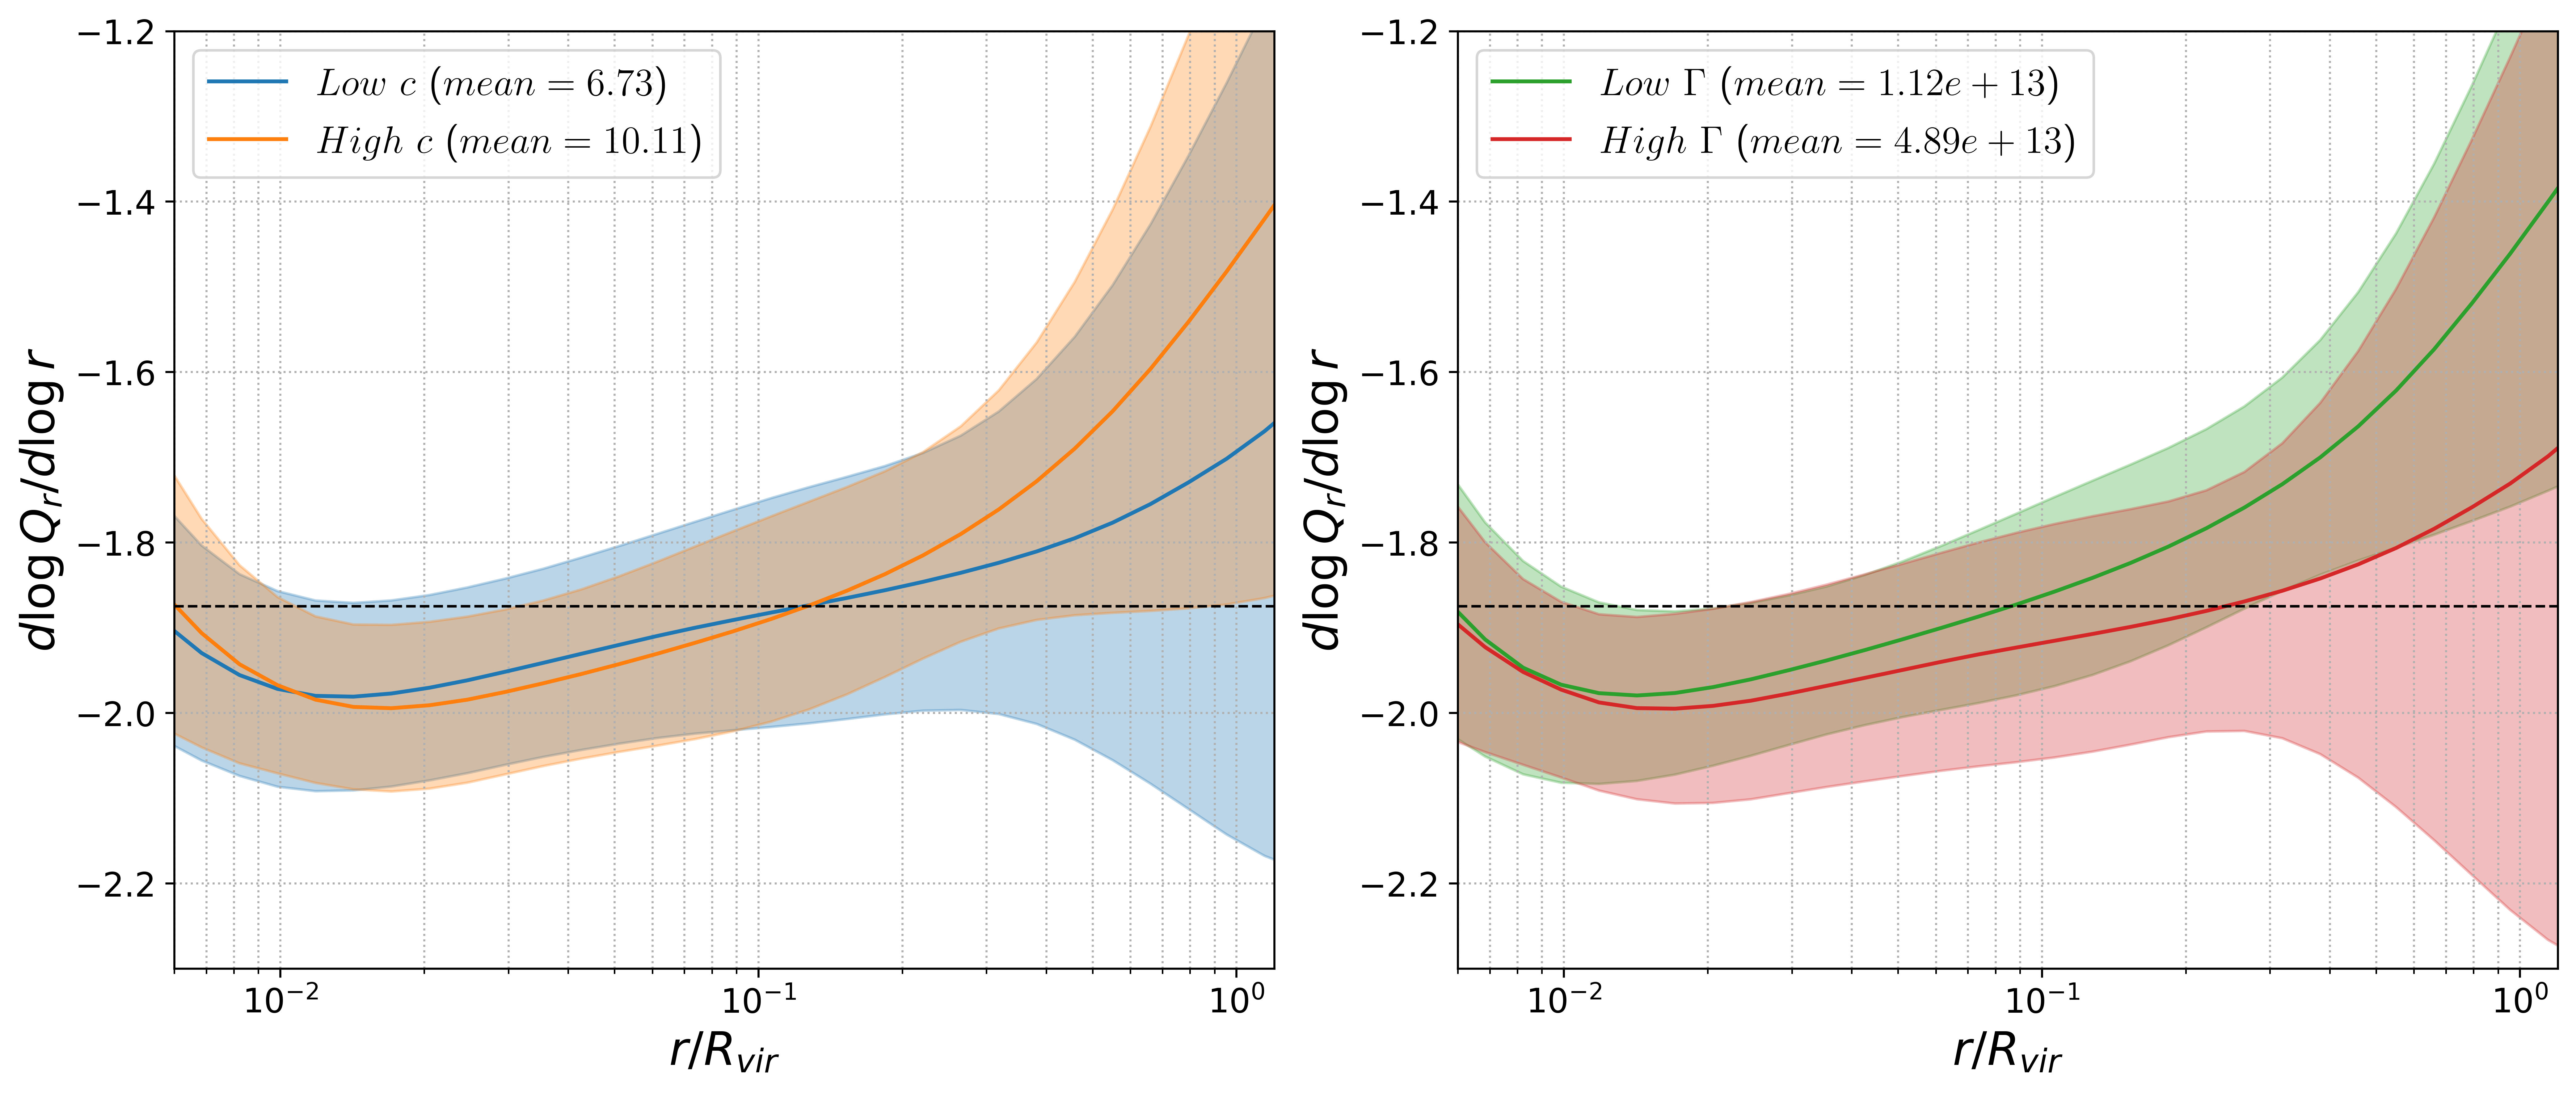

In [3]:
def plot_ppsd_slope_split_by_cgamma_vs_r():
    low_c_sr, high_c_sr = [], []
    low_g_sr, high_g_sr = [], []
    c_low_vals, c_high_vals = [], []
    g_low_vals, g_high_vals = [], []
    r_ref = None

    for suite in suite_names:
        dir_r = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        cdf = pd.read_csv(os.path.join(base_dir, "output", suite, "halo_concentrations.csv"))
        gdf = pd.read_csv(os.path.join(base_dir, "output", suite, "accretion_rates.csv"))
        cdict = dict(zip(cdf["halo_id"], cdf["cvir"]))
        gdict = dict(zip(gdf["halo_index"], gdf["gamma"]))

        sr_list, c_list, g_list = [], [], []
        for fn in sorted(os.listdir(dir_r)):
            if not fn.endswith(".csv"):
                continue
            idx = int(fn.split("_")[1])
            df = pd.read_csv(os.path.join(dir_r, fn))
            sr = df["slope_Q_r"].values
            c  = cdict.get(idx, np.nan)
            g  = gdict.get(idx, np.nan)
            if not (np.isfinite(c) and np.isfinite(g)):
                continue
            sr_list.append(sr)
            c_list.append(c)
            g_list.append(g)
            if r_ref is None:
                r_ref = df["r_scaled"].values

        sr_arr = np.stack(sr_list)
        c_arr  = np.array(c_list)
        g_arr  = np.array(g_list)

        # per-suite medians
        c_med = np.nanmedian(c_arr)
        g_med = np.nanmedian(g_arr)

        # split masks
        low_c_mask  = c_arr <= c_med
        high_c_mask = c_arr >  c_med
        low_g_mask  = g_arr <= g_med
        high_g_mask = g_arr >  g_med

        # accumulate
        low_c_sr .append(sr_arr[ low_c_mask])
        high_c_sr.append(sr_arr[ high_c_mask])
        low_g_sr .append(sr_arr[ low_g_mask])
        high_g_sr.append(sr_arr[ high_g_mask])
        c_low_vals .extend(c_arr[ low_c_mask])
        c_high_vals.extend(c_arr[ high_c_mask])
        g_low_vals .extend(g_arr[ low_g_mask])
        g_high_vals.extend(g_arr[ high_g_mask])

    # stack across all suites
    low_c_sr  = np.vstack(low_c_sr)
    high_c_sr = np.vstack(high_c_sr)
    low_g_sr  = np.vstack(low_g_sr)
    high_g_sr = np.vstack(high_g_sr)

    mean_c_low  = np.mean(c_low_vals)
    mean_c_high = np.mean(c_high_vals)
    mean_g_low  = np.mean(g_low_vals)
    mean_g_high = np.mean(g_high_vals)

    def plot_mean_std(ax, x, Y, mean_param, label, sci=False, color=None):
        μ = np.nanmean(Y, axis=0)
        σ = np.nanstd( Y, axis=0)
        fmt = rf"{mean_param:.2e}" if sci else rf"{mean_param:.2f}"
        label_text = rf"{label} ($mean = {fmt}$)"
        ax.plot(x, μ, label=label_text, color=color, lw=1.5)
        ax.fill_between(x, μ-σ, μ+σ, alpha=0.3, color=color)

    # make figure
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=600)
    plt.rcParams['text.usetex'] = True
    for ax in axes:
        ax.tick_params(axis='both', labelsize=13)
    # panel 1: by concentration
    plot_mean_std(axes[0], r_ref, low_c_sr,  mean_c_low,  r"$Low ~ c$",  color="C0")
    plot_mean_std(axes[0], r_ref, high_c_sr, mean_c_high, r"$High ~ c$", color="C1")
    axes[0].set_xscale("log")
    axes[0].set_xlabel(r"$r / R_{vir}$", fontsize=18)
    axes[0].set_ylabel(r"$d\log Q_r / d\log r$", fontsize=18)
    axes[0].legend(fontsize=15)
    axes[0].grid(which="both", linestyle=":")
    axes[0].axhline(-1.875, ls='--', color='black', lw=1)
    axes[0].set_xlim(6e-3,1.2)
    axes[0].set_ylim(-2.3,-1.2)

    # panel 2: by accretion
    plot_mean_std(axes[1], r_ref, low_g_sr,  mean_g_low,  r"$Low ~ \Gamma$", sci=True, color="C2")
    plot_mean_std(axes[1], r_ref, high_g_sr, mean_g_high, r"$High ~ \Gamma$",sci=True, color="C3")
    axes[1].set_xscale("log")
    axes[1].set_xlabel(r"$r / R_{vir}$", fontsize=18)
    axes[1].set_ylabel(r"$d\log Q_r / d\log r$", fontsize=18)
    axes[1].legend(fontsize=15)
    axes[1].grid(which="both", linestyle=":")
    axes[1].axhline(-1.875, ls='--', color='black', lw=1)
    axes[1].set_xlim(6e-3,1.2)
    axes[1].set_ylim(-2.3,-1.2)

    plt.savefig(os.path.join(out_dir, f"ppsd_slope_r_split.pdf"))
    plt.tight_layout()
    plt.show()
    plt.close(fig)

plot_ppsd_slope_split_by_cgamma_vs_r()

In [ ]:
def plot_ppsd_slope_split_by_cgamma_vs_M():
    low_c_sr, high_c_sr = [], []
    low_g_sr, high_g_sr = [], []
    c_low_vals, c_high_vals = [], []
    g_low_vals, g_high_vals = [], []
    m_ref = None

    for suite in suite_names:
        dir_m = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_m")
        cdf   = pd.read_csv(os.path.join(base_dir, "output", suite, "halo_concentrations.csv"))
        gdf   = pd.read_csv(os.path.join(base_dir, "output", suite, "accretion_rates.csv"))
        cdict = dict(zip(cdf["halo_id"], cdf["cvir"]))
        gdict = dict(zip(gdf["halo_index"], gdf["gamma"]))

        sr_list, c_list, g_list = [], [], []
        for fn in sorted(os.listdir(dir_m)):
            if not fn.endswith(".csv"):
                continue
            idx = int(fn.split("_")[1])
            df  = pd.read_csv(os.path.join(dir_m, fn))
            sr  = df["slope_Q_r"].values
            m   = df["m_scaled"].values
            c   = cdict.get(idx, np.nan)
            g   = gdict.get(idx, np.nan)
            if not (np.isfinite(c) and np.isfinite(g)):
                continue
            sr_list.append(sr)
            c_list.append(c)
            g_list.append(g)
            if m_ref is None:
                m_ref = m

        sr_arr = np.stack(sr_list)
        c_arr  = np.array(c_list)
        g_arr  = np.array(g_list)

        c_med = np.nanmedian(c_arr)
        g_med = np.nanmedian(g_arr)

        low_c_mask  = c_arr <= c_med
        high_c_mask = c_arr >  c_med
        low_g_mask  = g_arr <= g_med
        high_g_mask = g_arr >  g_med

        low_c_sr .append(sr_arr[ low_c_mask])
        high_c_sr.append(sr_arr[ high_c_mask])
        low_g_sr .append(sr_arr[ low_g_mask])
        high_g_sr.append(sr_arr[ high_g_mask])
        c_low_vals .extend(c_arr[ low_c_mask])
        c_high_vals.extend(c_arr[ high_c_mask])
        g_low_vals .extend(g_arr[ low_g_mask])
        g_high_vals.extend(g_arr[ high_g_mask])

    low_c_sr  = np.vstack(low_c_sr)
    high_c_sr = np.vstack(high_c_sr)
    low_g_sr  = np.vstack(low_g_sr)
    high_g_sr = np.vstack(high_g_sr)

    mean_c_low  = np.mean(c_low_vals)
    mean_c_high = np.mean(c_high_vals)
    mean_g_low  = np.mean(g_low_vals)
    mean_g_high = np.mean(g_high_vals)

    def plot_mean_std(ax, x, Y, mean_param, label, sci=False, color=None):
        μ   = np.nanmean(Y, axis=0)
        σ   = np.nanstd( Y, axis=0)
        fmt = f"{mean_param:.2e}" if sci else f"{mean_param:.2f}"
        ax.plot(x, μ, label=f"{label} (⟨{fmt}⟩, N={Y.shape[0]})",
                color=color, lw=1.5)
        ax.fill_between(x, μ-σ, μ+σ, alpha=0.3, color=color)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=600, sharey=True)

    # by concentration
    plot_mean_std(axes[0], m_ref, low_c_sr,  mean_c_low,  "Low c",  color="C0")
    plot_mean_std(axes[0], m_ref, high_c_sr, mean_c_high, "High c", color="C1")
    axes[0].set_xscale("log")
    axes[0].set_xlabel(r"$M / M_{vir}$")
    axes[0].set_ylabel(r"$d\log Q_r / d\log M$")
    axes[0].legend()
    axes[0].grid(which="both", linestyle=":")
    axes[0].set_xlim(1e-3, 1)

    # by accretion
    plot_mean_std(axes[1], m_ref, low_g_sr,  mean_g_low,  "Low γ", sci=True, color="C2")
    plot_mean_std(axes[1], m_ref, high_g_sr, mean_g_high, "High γ", sci=True, color="C3")
    axes[1].set_xscale("log")
    axes[1].set_xlabel(r"$M / M_{vir}$")
    axes[1].set_ylabel(r"$d\log Q_r / d\log M$")
    axes[1].legend()
    axes[1].grid(which="both", linestyle=":")
    axes[1].set_xlim(1e-3, 1)

    plt.savefig(os.path.join(out_dir, f"ppsd_slope_M_split.pdf"))
    plt.tight_layout()
    plt.show()
    plt.close(fig)

plot_ppsd_slope_split_by_cgamma_vs_M()